# Bidirectional Long-Short Term Memory (Bi-LSTM) for mnli

In [1]:
#import preprocessing, modeling, and evaluation libraries

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, classification_report


In [2]:
# loading training, validation and testing dataset
import pandas as pd

#training set
data_frame_train = pd.read_csv('./mnli dataset/sampled_training_data_ten_percent.csv')

#validation set
data_frame_validation = pd.read_csv('./mnli dataset/sampled_validation_data_ten_percent.csv')
                                    
#testing set                                  
data_frame_test = pd.read_csv('./mnli dataset/sampled_testing_data_five_percent.csv')


In [3]:
# replace NaN float with "missing" string values

def replaceNaN(df):
    
    df.fillna({'premise': 'missing'}, inplace=True)
    df.fillna({'hypothesis':'missing'}, inplace=True)
    
    return None


In [4]:
# training data frame

replaceNaN(data_frame_train)

data_frame_train


,premise,hypothesis,label,idx,label_text
0,"Jon lifted Susan into his arms, his muscles so...",Susan lifted Jon into the air.,2,207880,contradiction
1,and dropping children off at the sitter and pi...,The children are dropped off at the sitter onl...,0,263102,entailment
2,The Honorable Donna E. Shalala The Secretary o...,Donna E. Shalala is an honorable person for th...,1,299610,neutral
3,Scheduling of follow-up visits depends on type...,Most patients have a follow up two weeks after...,1,344508,neutral
4,This effect does not consider the additional j...,This technology is purely for environmental be...,2,128010,contradiction
...,...,...,...,...,...
31411,"Tommy's eyes opened as he read: ""Jane Finn found.",Jane Finn was very important to Tommy.,1,360356,neutral
31412,After a brief stint living in the Palazzo Vecc...,The Medici's official residence used to belong...,0,219442,entailment
31413,Doors of solid silver open onto the multicolor...,The doors contain more ivory than marble.,1,276936,neutral
31414,"You are not ill, I trust?",Do you feel good?,1,25208,neutral


In [5]:
# validation data frame 

replaceNaN(data_frame_validation)

data_frame_validation


,premise,hypothesis,label,idx,label_text
0,yeah well losing is i mean i'm i'm originally ...,The St. Louis Cardinals have always won.,2,3344,contradiction
1,Beside the fortress lies an 18th-century carav...,The fortress was built a number of years after...,1,3852,neutral
2,The twenty mastic villages known collectively ...,Mastihohoria is a collection of twenty mastic ...,0,5009,entailment
3,"Jamaican music ska and, especially, reggae has...",Reggae is the most popular music style in Jama...,1,5398,neutral
4,for me now the address is the same you know my...,I am able to receive mail at my workplace.,1,2335,neutral
...,...,...,...,...,...
977,so you know well a lot of the stuff you hear c...,They consider the West African music to be wor...,0,700,entailment
978,i think they prey on people's um inherent poli...,Some people like listening to recorded message...,1,6399,neutral
979,Rehnquist's conferences are no-nonsense.,Rehnquist was a respected justice.,1,6306,neutral
980,"The renowned Theban queen Nefertari, wife of R...",The renowned Theban queen Nefertari has a tomb...,2,2210,contradiction


In [6]:
# testing data frame

replaceNaN(data_frame_test)

data_frame_test


,premise,hypothesis,label,idx,label_text
0,"Jon lifted Susan into his arms, his muscles so...",Susan lifted Jon into the air.,2,207880,contradiction
1,and dropping children off at the sitter and pi...,The children are dropped off at the sitter onl...,0,263102,entailment
2,The Honorable Donna E. Shalala The Secretary o...,Donna E. Shalala is an honorable person for th...,1,299610,neutral
3,Scheduling of follow-up visits depends on type...,Most patients have a follow up two weeks after...,1,344508,neutral
4,This effect does not consider the additional j...,This technology is purely for environmental be...,2,128010,contradiction
...,...,...,...,...,...
15703,5 million for grants to local legal services p...,A large deal of money has been allocated to lo...,0,288859,entailment
15704,But reviewers agree that the recording succeed...,"Bartoli and Hampson save the recording, becaus...",1,376665,neutral
15705,"We know this, because later she asked Dorcas t...",Dorcas did not bring any.,1,287939,neutral
15706,uh again i mean people think it's expensive bu...,It is much more expensive than any New England...,2,185150,contradiction


In [7]:
# attributes of data frames

print(list(data_frame_train))
print(list(data_frame_validation))
print(list(data_frame_test))


['premise', 'hypothesis', 'label', 'idx', 'label_text']
['premise', 'hypothesis', 'label', 'idx', 'label_text']
['premise', 'hypothesis', 'label', 'idx', 'label_text']


In [8]:
# creating lists for training dataset

# premise, hypothesis, and labels declaration
premise_train = data_frame_train['premise'].values
hypothesis_train = data_frame_train['hypothesis'].values
label_train = data_frame_train['label'].values

# combining dependent variable and independent variables into list
# initializing training set
x_train = list(zip(premise_train,hypothesis_train))
y_train = list(label_train)

print(x_train[:5]) #print only the first 5 elements as data rate can exceed for such large list and show an error
print(" ")

print(y_train[:5])


[('Jon lifted Susan into his arms, his muscles sore from combat.', 'Susan lifted Jon into the air.'), ('and dropping children off at the sitter and picking children up from school and', 'The children are dropped off at the sitter only to be picked up from school.'), ('The Honorable Donna E. Shalala The Secretary of Health and Human Services', 'Donna E. Shalala is an honorable person for the Health and human services.'), ('Scheduling of follow-up visits depends on type of medical problem or injury.', 'Most patients have a follow up two weeks after the initial visit.'), ('This effect does not consider the additional job-gain potential from U.S.-based equipment suppliers that export to other countries the clean-air technology know-how they will gain from these clean-air programs.', 'This technology is purely for environmental benefit.')]
 
[2, 0, 1, 1, 2]


In [9]:
# creating lists for validation dataset

# premise, hypothesis, and labels declaration
premise_validation = data_frame_validation['premise'].values
hypothesis_validation = data_frame_validation['hypothesis'].values
label_validation = data_frame_validation['label'].values

# combining dependent variable and independent variables into list
# initializing validation set
x_validation = list(zip(premise_validation,hypothesis_validation))
y_validation = list(label_validation)

print(x_validation[:5]) # print only the first 5 elements as data rate can exceed for such large list and show an error
print(" ")

print(y_validation[:5])


[("yeah well losing is i mean i'm i'm originally from Saint Louis and Saint Louis Cardinals when they were there were uh a mostly a losing team but", 'The St. Louis Cardinals have always won.'), ('Beside the fortress lies an 18th-century caravanserai, or inn, which has been converted into a hotel, and now hosts regular folklore evenings of Turkish dance and music.', 'The fortress was built a number of years after the caravanserai.'), ('The twenty mastic villages known collectively as mastihohoria were built by the Genoese in the 14 15th centuries.', 'Mastihohoria is a collection of twenty mastic villages built be the genoese.'), ('Jamaican music ska and, especially, reggae has since the 1970s been exported and enjoyed around the world.', 'Reggae is the most popular music style in Jamaica.'), ('for me now the address is the same you know my my office address', 'I am able to receive mail at my workplace.')]
 
[2, 1, 0, 1, 1]


In [10]:
# creating lists for test dataset

# premise, hypothesis, and labels declaration
premise_test = data_frame_test['premise'].values
hypothesis_test = data_frame_test['hypothesis'].values
label_test = data_frame_test['label'].values

# combining dependent variable and independent variables into list
# initializing validation set
x_test = list(zip(premise_test,hypothesis_test))
y_test = list(label_test)

print(x_test[:5]) # print only the first 5 elements as data rate can exceed for such large list and show an error
print(" ")

print(y_test[:5])


[('Jon lifted Susan into his arms, his muscles sore from combat.', 'Susan lifted Jon into the air.'), ('and dropping children off at the sitter and picking children up from school and', 'The children are dropped off at the sitter only to be picked up from school.'), ('The Honorable Donna E. Shalala The Secretary of Health and Human Services', 'Donna E. Shalala is an honorable person for the Health and human services.'), ('Scheduling of follow-up visits depends on type of medical problem or injury.', 'Most patients have a follow up two weeks after the initial visit.'), ('This effect does not consider the additional job-gain potential from U.S.-based equipment suppliers that export to other countries the clean-air technology know-how they will gain from these clean-air programs.', 'This technology is purely for environmental benefit.')]
 
[2, 0, 1, 1, 2]


In [11]:
# tokenization
#convert words into integers
texts = [pair[0] + " " + pair[1] for pair in x_train] + [pair[0] + " " + pair[1] for pair in x_validation] + [pair[0] + " " + pair[1] for pair in x_test]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)


In [12]:
# Convert text to sequences
x_train_seq = tokenizer.texts_to_sequences([pair[0] + " " + pair[1] for pair in x_train])
x_validation_seq = tokenizer.texts_to_sequences([pair[0] + " " + pair[1] for pair in x_validation])
x_test_seq = tokenizer.texts_to_sequences([pair[0] + " " + pair[1] for pair in x_test])


In [13]:
# Pad the sequences to ensure consistent input size
max_sequence_length = 100  # Adjust based on your data
x_train_pad = pad_sequences(x_train_seq, maxlen=max_sequence_length)
x_validation_pad = pad_sequences(x_validation_seq, maxlen=max_sequence_length)
x_test_pad = pad_sequences(x_test_seq, maxlen=max_sequence_length)


In [14]:
# Convert labels data type to numpy arrays
y_train = np.array(y_train)
y_validation = np.array(y_validation)
y_test = np.array(y_test)


In [15]:
# Build the model
embedding_dimension = 300 # Adjust based on pre-trained word vectors (like GloVe) or your needs

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1,output_dim=embedding_dimension))
model.add(SpatialDropout1D(0.2)) # dropout regularization for input layers
model.add(Bidirectional(LSTM(100,dropout=0.2,recurrent_dropout=0.2))) #BiLSTM layers and recurrent dropout for hidden layers
model.add(Dense(3,activation="softmax")) # fully connected output layer for 3 classes (entailment, contradiction, neutral)


In [16]:
# compile the model for setting up the loss function, optimization for gradient loss, evaluation


model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
#model.compile(loss='sparse_categorical_crossentropy',
 ##            metrics=['accuracy'])

In [17]:
#from tensorflow.keras.optimizers import Adam

# Instantiate Adam optimizer with custom learning rate and weight decay
#optimizer = Adam(learning_rate=2e-5, weight_decay=0.01)

# Compile the model
##             optimizer=optimizer,  # Use the optimizer object
  #            metrics=['accuracy'])

In [18]:
# get the summary of the model
# before training
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         11511000  
                                                                 
 spatial_dropout1d (SpatialD  (None, None, 300)        0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 200)              320800    
 l)                                                              
                                                                 
 dense (Dense)               (None, 3)                 603       
                                                                 
Total params: 11,832,403
Trainable params: 11,832,403
Non-trainable params: 0
_________________________________________________________________


In [19]:
# train the configured model
final_model = model.fit(x_train_pad,y_train,epochs=1,batch_size=64,validation_data=(x_validation_pad,y_validation))


491/491 [==============================] - 423s 851ms/step - loss: 1.0307 - accuracy: 0.4595 - val_loss: 1.0039 - val_accuracy: 0.4705


In [20]:
# Evaluate the model on the validation set with eval_batch_size
eval_results = model.evaluate(
    x_validation_pad,  # Validation input data
    y_validation,      # Validation labels
    batch_size=16       # Set the batch size for evaluation
)

print(f"Evaluation results: {eval_results}")

62/62 [==============================] - 2s 27ms/step - loss: 1.0039 - accuracy: 0.4705
Evaluation results: [1.0038670301437378, 0.4704684317111969]


In [21]:
# after training
#summary of the trained model
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         11511000  
                                                                 
 spatial_dropout1d (SpatialD  (None, None, 300)        0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 200)              320800    
 l)                                                              
                                                                 
 dense (Dense)               (None, 3)                 603       
                                                                 
Total params: 11,832,403
Trainable params: 11,832,403
Non-trainable params: 0
_________________________________________________________________


In [22]:
# prediction on test set
y_prediction = model.predict(x_test_pad)
y_prediction_classes = np.argmax(y_prediction,axis=1)


491/491 [==============================] - 66s 133ms/step


In [23]:
# prediction results
print("Test dataset: {}".format(x_test_pad))
print(" ")
print("Predictions: {}".format(y_prediction_classes))


Test dataset: [[   0    0    0 ...   98    1  293]
 [   0    0    0 ...   57   25  243]
 [   0    0    0 ...    4  527  178]
 ...
 [   0    0    0 ...   20  755   82]
 [   0    0    0 ... 1410  169  243]
 [   0    0    0 ... 1206 1285 2066]]
 
Predictions: [0 2 0 ... 2 2 2]


In [24]:
# evaluation of the model for test dataset
accuracy = accuracy_score(y_test,y_prediction_classes)
print("Accuracy:{:.2f}".format(accuracy * 100))


Accuracy:61.08


In [25]:
print(y_test)


[2 0 1 ... 1 2 2]


In [26]:
# classification report
print(classification_report(y_test,y_prediction_classes,target_names=["Contradiction", "Neutral", "Entailment"]))


               precision    recall  f1-score   support

Contradiction       0.55      0.69      0.61      5219
      Neutral       0.63      0.53      0.58      5194
   Entailment       0.68      0.61      0.64      5295

     accuracy                           0.61     15708
    macro avg       0.62      0.61      0.61     15708
 weighted avg       0.62      0.61      0.61     15708



In [27]:
# confusion matrix for multi-class (3-classes)
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test,y_prediction_classes)

print("Confusion Matrix:")
print(" ")
print(cm)


Confusion Matrix:
 
[[3598  840  781]
 [1683 2771  740]
 [1280  790 3225]]


In [28]:
# count total number of occurences
def countTotal(y_classes):

    m = total_contradiction = total_neutral = total_entailment = 0

    while(m<len(y_classes)):
        if(y_classes[m] == 0):
            total_contradiction = total_contradiction + 1
        elif(y_classes[m] == 1):
            total_neutral = total_neutral + 1
        else:
            total_entailment = total_entailment + 1

        m = m + 1

    print("Total Contradiction => {}".format(total_contradiction))
    print("Total Neutral => {}".format(total_neutral))
    print("Total Entailment => {}".format(total_entailment))

print("For Actual:")
countTotal(y_test)
print(" ")

print("For Prediction:")
countTotal(y_prediction_classes)


For Actual:
Total Contradiction => 5219
Total Neutral => 5194
Total Entailment => 5295
 
For Prediction:
Total Contradiction => 6561
Total Neutral => 4401
Total Entailment => 4746


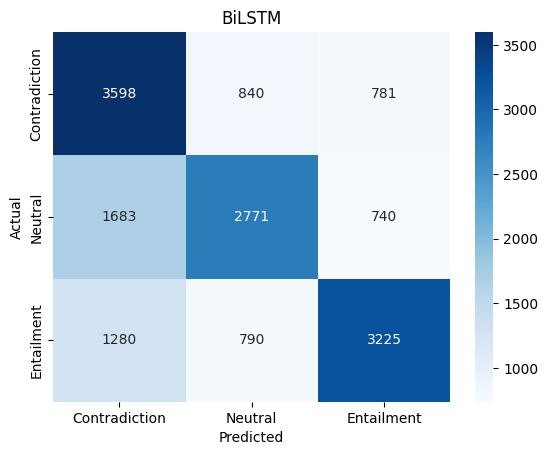

In [29]:
# using heatmap for visualization of confusion matrix
import seaborn as sb
import matplotlib.pyplot as plt

sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Contradiction', 'Neutral', 'Entailment'], yticklabels=['Contradiction', 'Neutral', 'Entailment'])
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.title('BiLSTM')
plt.show()
